# Summaries
the idea is to use summaries for each teime series,
pros:
- less features
- easy to compute

cons:
- breaking the time dependency

In [2]:
%load_ext autoreload
%autoreload 2
from util import to_corr_matrix,to_matrix

import pandas as pd
import numpy as np

In [7]:
df_train = pd.read_csv('data\\train.csv')
# df_train.to_parquet('train.parquet')
# df_train = pd.read_parquet('train.parquet')
df_ts = df_train.iloc[:,5:] # timeseries features only
df_train['y_s'] = df_train.y > 1 # simplified y: label 0 for 1 and 1 for 2,3 



In [9]:
summaries = {
    'max': np.max,
    'min': np.min,
    'mean': np.mean,
    'q05': lambda x: np.quantile(x, q=0.05),
    'q25': lambda x: np.quantile(x, q=0.25),
    'median':lambda x: np.quantile(x, q=0.5),
    'q75': lambda x: np.quantile(x, q=0.75),
    'q95': lambda x: np.quantile(x, q=0.95),
    'sd' : np.std
}

from util import apply_summaries
X = apply_summaries(df_ts, summaries)
X


,max_E1A,max_E1H,max_E1P,max_E1V,max_E2A,max_E2H,max_E2P,max_E2V,max_E3A,max_E3H,...,sd_E4P,sd_E4V,sd_M1A,sd_M1H,sd_M1P,sd_M1V,sd_M2A,sd_M2H,sd_M2P,sd_M2V
0,3.106584,12.067687,19.177058,2.904495,2.064329,7.027072,6.340742,2.982987,3.890517,14.949150,...,1.255505,1.040069,0.050175,0.169479,0.088162,0.068187,0.183300,0.289455,0.225674,0.104515
1,1.973324,3.334162,3.230021,2.075948,2.325271,3.196759,3.119100,2.203837,2.168119,4.257831,...,0.680791,1.531023,0.280836,0.393032,0.177601,0.285567,0.289014,0.280970,0.150312,0.194065
2,4.905155,3.816043,4.624890,1.912259,3.906155,4.914904,6.291021,3.556789,2.485419,5.553386,...,1.161188,0.756567,0.360426,0.454909,0.150276,0.213916,0.383181,0.270697,0.114646,0.201189
3,4.146159,12.211521,20.694593,1.946000,2.528676,12.353929,17.187908,1.648643,3.365520,19.111603,...,2.090017,0.715431,0.081689,0.131402,0.031252,0.075495,0.106077,0.291366,0.154365,0.128690
4,2.507720,6.752539,6.668999,3.012293,2.204402,7.998847,8.025621,2.356230,2.283782,10.433940,...,1.244459,0.589475,0.065238,0.124671,0.038525,0.101876,0.076700,0.144280,0.062229,0.083936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,2.627815,10.701584,12.654741,2.283455,2.531638,7.849816,6.931436,2.794771,2.605332,11.994953,...,0.777384,0.607655,0.099341,0.165845,0.079561,0.110513,0.075273,0.244180,0.168393,0.115389
659,2.733922,4.979573,8.429594,3.103308,1.884466,7.571239,13.081043,1.217670,2.633123,6.707066,...,1.022331,0.680970,0.189324,0.098224,0.051483,0.257583,0.193518,0.155501,0.105324,0.149087
660,4.631380,12.068901,14.897799,4.111245,2.937032,8.865655,13.798335,2.973656,10.616217,12.786204,...,1.368502,0.962709,0.146667,0.109372,0.050642,0.134140,0.183376,0.252670,0.187084,0.217151
661,2.340140,3.257143,9.396940,3.182236,4.438345,5.194028,5.873247,3.869224,3.320506,10.530150,...,0.758045,0.898324,0.284951,0.320754,0.093320,0.150654,0.389834,0.335866,0.199616,0.195892


## Model fit

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
x_train, x_test, y_train, y_test = train_test_split(X, df_train.y_s, test_size=0.3, stratify=df_train.y_s)
model = SVC(C=2, class_weight='balanced')
model.fit(x_train,y_train)

SVC(C=2, class_weight='balanced')

(array([[125,  61],
        [  7,   6]], dtype=int64),
 0.5667907361455748)

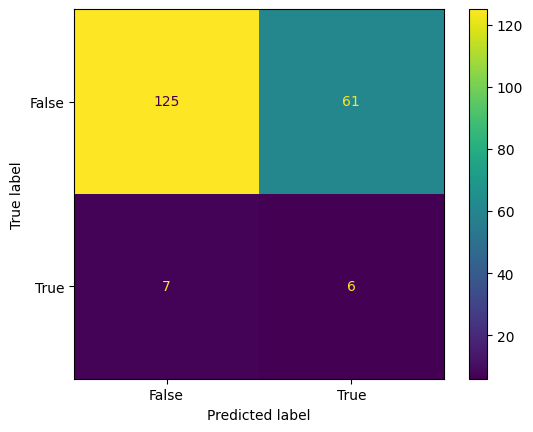

In [12]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay

y_hat = model.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)

confusion_matrix(y_test,y_hat),balanced_accuracy_score(y_test, y_hat)

## Cross-validation

In [44]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
model = SVC(class_weight='balanced')
params = {'C' : np.linspace(0.1,3,50),
          'kernel':['poly','rbf','linear']}
skf = StratifiedKFold(n_splits=5)

In [46]:
cv = GridSearchCV(
    model, 
    param_grid=params, 
    scoring='balanced_accuracy', 
    n_jobs=-1, 
    cv=skf.split(X, df_train.y)
)
cv.fit(X,df_train.y)

cv.best_params_, cv.best_score_

C:\Users\laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


({'C': 1.579591836734694, 'kernel': 'poly'}, 0.6271889400921659)

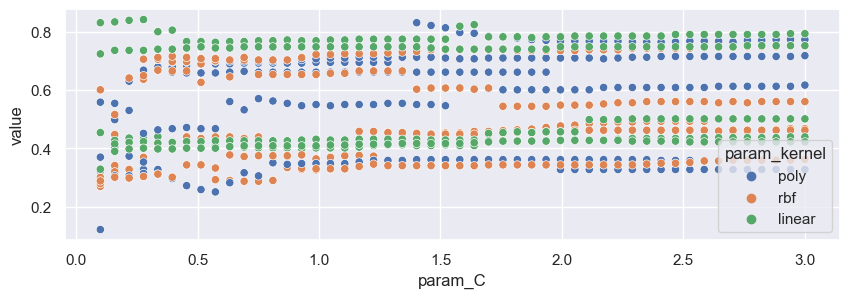

In [47]:
from util import plot_cv_results
plot_cv_results(cv, 'param_C', 'param_kernel')

In [30]:
y_hat = cv.predict(X)
confusion_matrix(df_train.y, y_hat),balanced_accuracy_score(df_train.y, y_hat), y_test.mean()

(array([[241, 376,   3],
        [  3,  36,   0],
        [  0,   1,   3]], dtype=int64),
 0.687262200165426,
 0.06532663316582915)

# Submission

In [18]:
model_final = SVC(C=2, class_weight='balanced')
model_final.fit(X, df_train.y)

SVC(C=2, class_weight='balanced')

In [19]:
df_sub = pd.read_csv('data\\test.csv')
X_sub = apply_summaries(df_sub.iloc[:,4:], funcs=summaries)

In [27]:
from datetime import datetime
y_sub = model_final.predict(X_sub)
submission_df = pd.DataFrame(y_sub,columns=['y'])
submission_df['id'] = df_sub.id
submission_df.set_index('id', inplace=True)
submission_df.y = 2-submission_df.y
submission_df.to_csv(f'data\\submissions\\summary_{datetime.now().strftime("%H.%M_%d")}.csv')